# load the data

In [3]:
import scipy.io as sio
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
# number = 1
# filename = os.path.join(os.path.dirname(__file__), "imu/imuRaw" + str(number) + ".mat")
# imuRaw = io.loadmat(filename)

# load the IMU dataset
imuRaw1 = sio.loadmat("./imu/imuRaw1.mat")
imuRaw2 = sio.loadmat("./imu/imuRaw2.mat")
imuRaw3 = sio.loadmat("./imu/imuRaw3.mat")

# load the Vicon dataset
viconRot1 = sio.loadmat("./vicon/viconRot1.mat")
viconRot2 = sio.loadmat("./vicon/viconRot2.mat")
viconRot3 = sio.loadmat("./vicon/viconRot3.mat")

print("IMU dataset's keys:", imuRaw1.keys())
print("Vicon dataset's keys:", viconRot1.keys())


IMU dataset's keys: dict_keys(['__header__', '__version__', '__globals__', 'vals', 'ts'])
Vicon dataset's keys: dict_keys(['__header__', '__version__', '__globals__', 'rots', 'ts'])


# Preprocess the data

In [11]:
'''
the metric convertor to switch between
Rotation matrix
RPY
quaternion
'''

class convertor:
    def __init__(self):
        pass
    def fromMatrixToRPY(self,rot_matrix):
        ## this method change the rots matrix into RPY
        roll = np.arctan2(rot_matrix[2,1],rot_matrix[2,2])
        pitch = np.arctan2(-rot_matrix[2,0],np.sqrt(rot_matrix[2,1]**2 + rot_matrix[2,2]**2))
        yaw = np.arctan2(rot_matrix[1,0],rot_matrix[0,0])
        return roll, pitch, yaw
    def fromAccToRPY(self,accX, accY, accZ):
        roll = np.arctan2(accY, accZ)
        pitch = np.arctan2(-accX, np.sqrt(accY**2 + accZ**2))
#         roll = np.arctan2(accY, accZ)
#         pitch = np.sin(-accX)
        return roll, pitch
    def fromDeltaTVelToRPY(self,delta_t, wx_vel, wy_vel, wz_vel):
        delta_roll = delta_t * wx_vel
        delta_pitch = delta_t * wy_vel
        delta_yaw = delta_t * wz_vel
        return delta_roll, delta_pitch, delta_yaw

In [12]:
class RPYVect:
    def __init__(self):
        pass
    def rpytsVectFromVicon(self, Vicon_rots, Vicon_ts):
        # read in the data
        rots_matries = Vicon_rots
        rots_ts = Vicon_ts
        # record the roll-pitch-yaw
        roll_list = []
        pitch_list = []
        yaw_list = []
        # loop through the matries
        # set the convertor
        convt = convertor()
        for i in range(rots_matries.shape[2]):
            matrix = rots_matries[:,:,i]
#             print(matrix)
            # convert the matrix to the rpy system
            roll, pitch, yaw = convt.fromMatrixToRPY(matrix)
            # record rpy
            roll_list.append(roll)
            pitch_list.append(pitch)
            yaw_list.append(yaw)
        return roll_list, pitch_list, yaw_list, rots_ts
    
    def rpytsVectFromAcc(self,normal_IMU_vals,normal_IMU_ts):
#         print("----------------------------------------------------")
#         print(normal_IMU_vals[:,:3])
        # get the acc part of the normal_IMU_dict
        accs = normal_IMU_vals[:,:3]
#         print("accs shape",accs.shape)
        # record the roll & pitch
        roll_list = []
        pitch_list = []
        # set the convertor
        convt = convertor()
        for i in range(accs.shape[0]):
            accX, accY, accZ = accs[i,:]
            # compute the roll & pitch
            roll, pitch = convt.fromAccToRPY(accX, accY, accZ)
            roll_list.append(roll)
            pitch_list.append(pitch)
        return roll_list, pitch_list, normal_IMU_ts
    
    
    def rpytsVectFromAnguVel(self,init_rpy,normal_IMU_vals,normal_IMU_ts):
        # record the init rpy
        init_roll, init_pitch, init_yaw = init_rpy
        roll_list = [init_roll]
        pitch_list = [init_pitch]
        yaw_list = [init_yaw]
        
        # get the angu_vel part of the normal_IMU_dict
        angu_Vels = normal_IMU_vals[:,3:]
        angu_Vels_X = normal_IMU_vals[:,3]
        angu_Vels_Y = normal_IMU_vals[:,4]
        angu_Vels_Z = normal_IMU_vals[:,5]
        
        ## loop over the time and integrate the angular velocity
        # set the convertor
        convt = convertor()
        for i in range(1, angu_Vels.shape[0]):
            # get the delta time
            delta_t = normal_IMU_ts[i] - normal_IMU_ts[i-1]
            # get the angular velocity
#             print(angu_Vels_X.shape)
            angu_velX = angu_Vels_X[i-1]
            angu_velY = angu_Vels_Y[i-1]
            angu_velZ = angu_Vels_Z[i-1]
#             print("angular velocity X:",angu_velX)
#             print("angular velocity Y:",angu_velY)
#             print("angular velocity Z:",angu_velZ)
            delta_roll, delta_pitch, delta_yaw = convt.fromDeltaTVelToRPY(delta_t, angu_velX, angu_velY, angu_velZ)
            
            # add the delta to the list
            roll_list.append(delta_roll)
            pitch_list.append(delta_pitch)
            yaw_list.append(delta_yaw)
        # cumsum the list to get the angulars at each time stamp    
        roll_list = np.cumsum(roll_list)
        pitch_list = np.cumsum(pitch_list)
        yaw_list = np.cumsum(yaw_list)
        return roll_list, pitch_list, yaw_list, normal_IMU_ts
            
        # 
        

IMU ACC data:
 [[-0.01995 -0.01995 -0.01995 ... -0.01995 -0.01995 -0.01995]
 [-0.      -0.      -0.      ...  0.095    0.095    0.095  ]
 [ 9.88     9.88     9.975   ...  9.88     9.88     9.975  ]]
acceleration check:
 [9.88002014 9.88002014 9.97501995 ... 9.88047686 9.88047686 9.97547232]
imu angu [[ 0.00555 -0.00945  0.00555 ... -0.00945  0.00555 -0.00945]
 [ 0.012    0.012   -0.003   ... -0.003    0.012   -0.003  ]
 [ 0.0051  -0.0099   0.0051  ... -0.0099  -0.0099  -0.0099 ]]
concatenate these two transformed dataset
normal_IMU_vals shape: (5645, 6)
0.005550000000000068 0.01200000000000017 0.005099999999999625
time lens: (5645,)
UKF iteration 1
init sigma mear [[-1.07296862e-03 -1.50949467e-01  9.79652248e+00  7.17434536e-03
   1.13882436e-02  4.57182825e-03]
 [ 1.50741906e-01  8.65407629e-04  9.79652248e+00  7.17434536e-03
   1.13882436e-02  4.57182825e-03]
 [-1.07296862e-03  8.65407629e-04  9.79769846e+00  7.17434536e-03
   1.13882436e-02  4.57182825e-03]
 [-1.07296862e-03  8.654

true mear [-1.995e-02 -0.000e+00  9.880e+00  5.550e-03 -3.000e-03  5.100e-03]
pred mear [   2.65593195    0.57313366   -5.63015303 -142.63430801   -1.23286239
 -122.13367623]
UKF iteration 7
init sigma mear [[ -0.42246295   0.58139426  -9.77601203 179.74882064   1.53490149
  151.50407796]
 [ -1.88932266   9.50281871   1.47668347 179.74882064   1.53490149
  151.50407796]
 [  5.20841686  -5.2305996   -6.44691088 179.74882064   1.53490149
  151.50407796]
 [  3.43251636  -8.58870997  -3.23798681 179.88731478   1.53490149
  151.50407796]
 [  3.4333769   -8.58844988  -3.23776393 179.74904234   1.67125331
  151.50407796]
 [  3.43321413  -8.58849338  -3.23782123 179.74882053   1.53490155
  151.64041822]
 [  2.22181496  -5.08529135   8.07419391 179.74882064   1.53490149
  151.50407796]
 [ -4.75585041   7.11342358   4.77719715 179.74882064   1.53490149
  151.50407796]
 [  7.45642788  -5.69536913  -2.82694191 179.74882064   1.53490149
  151.50407796]
 [  3.43395092  -8.5882717   -3.23762758 179.6

true mear [-1.995e-02 -0.000e+00  9.880e+00 -9.450e-03  1.200e-02  5.100e-03]
pred mear [-4.55891063e-01  5.05184005e+00 -1.20217731e+00 -6.54028616e+06
 -6.11048142e+04 -5.51452355e+06]
UKF iteration 13
init sigma mear [[-6.46585877e+00 -7.05104770e+00  2.12303750e+00  1.15347637e+07
   1.06949020e+05  9.64885071e+06]
 [ 3.56439900e+00  6.44987467e+00 -6.46277282e+00  1.15347637e+07
   1.06949020e+05  9.64885071e+06]
 [ 4.90011567e+00 -4.24109111e+00 -7.35241411e+00  1.15347637e+07
   1.06949020e+05  9.64885071e+06]
 [ 1.41315688e+00  9.65993002e+00  8.59339245e-01  1.15347639e+07
   1.06949020e+05  9.64885071e+06]
 [ 1.41320551e+00  9.65991849e+00  8.59388685e-01  1.15347637e+07
   1.06949212e+05  9.64885071e+06]
 [ 1.41316490e+00  9.65992811e+00  8.59347406e-01  1.15347637e+07
   1.06949020e+05  9.64885091e+06]
 [ 4.24226329e+00 -8.11898035e+00 -3.48112351e+00  1.15347637e+07
   1.06949020e+05  9.64885071e+06]
 [-1.74739212e+00  5.97606265e+00  7.56654166e+00  1.15347637e+07
   1.06

true mear [-1.995e-02 -0.000e+00  9.880e+00 -9.450e-03  1.200e-02  5.100e-03]
pred mear [ 9.08969416e-01 -2.52888955e+00  7.93087063e+00 -3.93197692e+11
 -3.75959143e+09 -3.29811078e+11]
UKF iteration 19
init sigma mear [[ 8.96448422e+00 -3.59985840e+00 -1.64351218e+00  8.45548211e+11
   8.04365187e+09  7.05494041e+11]
 [ 5.84473053e+00 -3.90956035e+00 -6.82690056e+00  8.45548211e+11
   8.04365187e+09  7.05494041e+11]
 [-3.61838959e+00  4.85743065e+00 -7.70741637e+00  8.45548211e+11
   8.04365187e+09  7.05494041e+11]
 [-3.84351841e-01  6.85898176e+00 -6.99224699e+00  8.45548211e+11
   8.04365187e+09  7.05494041e+11]
 [-3.81956775e-01  6.85895290e+00 -6.99240622e+00  8.45548211e+11
   8.04365187e+09  7.05494041e+11]
 [-3.81034314e-01  6.86008545e+00 -6.99134509e+00  8.45548211e+11
   8.04365187e+09  7.05494041e+11]
 [-8.83465657e+00  1.22555928e+00  4.06069313e+00  8.45548211e+11
   8.04365187e+09  7.05494041e+11]
 [-5.99489889e+00  6.57626170e+00  4.10600886e+00  8.45548211e+11
   8.04

true mear [-1.995e-02 -0.000e+00  9.880e+00 -9.450e-03 -3.000e-03  5.100e-03]
pred mear [ 2.20575935e+00 -7.40771260e-01  3.74153005e+00 -6.63670637e+15
 -3.90799859e+14 -2.28737789e+16]
UKF iteration 25
init sigma mear [[-7.23600714e+00  4.05337411e+00 -5.22464784e+00  9.67999548e+15
   9.49861216e+14  3.45053277e+15]
 [-1.33723897e+00  9.07185159e+00 -3.46234058e+00  9.67999548e+15
   9.49861216e+14  3.45053277e+15]
 [-5.13870287e+00  5.54086324e+00 -6.24355006e+00  9.67999548e+15
   9.49861216e+14  3.45053277e+15]
 [ 1.50271067e+00 -9.47455576e+00  1.99645521e+00  9.67999548e+15
   9.49861216e+14  3.45053277e+15]
 [ 2.94151473e+00 -6.88909269e+00  6.31510734e+00  9.67999548e+15
   9.49861216e+14  3.45053277e+15]
 [ 2.63035717e+00 -9.10126029e+00  2.50107282e+00  9.67999548e+15
   9.49861216e+14  3.45053277e+15]
 [ 5.32555542e+00  7.96831794e+00  2.04384855e+00  9.67999548e+15
   9.49861216e+14  3.45053277e+15]
 [-1.62182212e+00  9.55477978e+00 -1.46377076e+00  9.67999548e+15
   9.49

true mear [-1.995e-02 -0.000e+00  9.880e+00  5.550e-03  1.200e-02  5.100e-03]
pred mear [ 6.65863891e+00 -2.62717964e+00 -1.71241836e+00  4.43266743e+14
  1.09565377e+15 -4.01781234e+11]
UKF iteration 31
init sigma mear [[ 9.57808527e+00 -1.74955536e+00 -1.10491412e+00 -7.92494891e+15
  -3.10264311e+16  2.83882284e+11]
 [-7.64493685e+00  1.35751491e+00  5.97857190e+00 -7.92494891e+15
  -3.10264311e+16  2.83882284e+11]
 [-7.82725742e+00  3.71707670e+00  4.57815811e+00 -7.92494891e+15
  -3.10264311e+16  2.83882284e+11]
 [-3.52629356e+00  9.07286638e+00  1.14295741e+00 -7.92494891e+15
  -3.10264311e+16  2.83882284e+11]
 [-3.67815636e+00  9.02801474e+00  1.01240658e+00 -7.92494891e+15
  -3.10264311e+16  2.83882284e+11]
 [-3.67919025e+00  9.03112543e+00  9.80478812e-01 -7.92494891e+15
  -3.10264311e+16  2.83882284e+11]
 [-5.58380907e+00 -8.05344102e+00  3.24191362e-02 -7.92494891e+15
  -3.10264311e+16  2.83882284e+11]
 [ 4.09706852e+00  7.34320705e+00 -5.03571545e+00 -7.92494891e+15
  -3.10

true mear [ 7.505e-02 -0.000e+00  9.880e+00 -9.450e-03 -3.000e-03  5.100e-03]
pred mear [ 1.03167112e+00 -2.64217393e+00  3.64767320e+00  3.46794944e+09
  2.83450535e+09 -9.27311748e+15]
UKF iteration 37
init sigma mear [[ 9.41064325e+00 -2.21532810e+00  1.59397041e+00  1.21047778e+12
  -1.13641753e+12  1.13527599e+16]
 [-9.24749886e+00  2.04933066e+00  2.51710283e+00  1.21047778e+12
  -1.13641753e+12  1.13527599e+16]
 [-9.58960803e+00  2.00359887e+00  2.96117689e-01  1.21047778e+12
  -1.13641753e+12  1.13527599e+16]
 [-6.12574388e+00 -7.63729047e+00 -4.34714438e-01  1.21047778e+12
  -1.13641753e+12  1.13527599e+16]
 [-6.12609314e+00 -7.63699303e+00 -4.35021240e-01  1.21047778e+12
  -1.13641753e+12  1.13527599e+16]
 [-6.12515534e+00 -7.63633126e+00 -4.59294015e-01  1.21047778e+12
  -1.13641753e+12  1.13527599e+16]
 [-4.13081815e+00  8.80363860e+00 -1.22557132e+00  1.21047778e+12
  -1.13641753e+12  1.13527599e+16]
 [ 4.15617666e+00 -8.39376583e+00 -2.88109329e+00  1.21047778e+12
  -1.13

true mear [-1.995e-02 -0.000e+00  9.880e+00  2.055e-02 -3.000e-03  5.100e-03]
pred mear [-4.28794111e+00 -2.15120707e+00  3.99548724e+00 -2.22573193e+15
 -4.79130604e+14 -2.46332919e+08]
UKF iteration 43
init sigma mear [[-7.66598285e-01 -6.99575147e+00  6.81688633e+00  1.16806450e+15
   1.06936192e+16  3.03263428e+08]
 [-7.21736957e+00 -3.25098741e+00 -5.78075433e+00  1.16806450e+15
   1.06936192e+16  3.03263428e+08]
 [ 6.07015326e+00 -7.30174429e+00  2.41681064e+00  1.16806450e+15
   1.06936192e+16  3.03263428e+08]
 [ 6.39585608e+00 -5.32616969e+00  5.16896483e+00  1.16806450e+15
   1.06936192e+16  3.03263428e+08]
 [ 8.11587557e+00 -5.35784162e+00 -1.20205377e+00  1.16806450e+15
   1.06936192e+16  3.03263428e+08]
 [ 8.11621497e+00 -5.35737553e+00 -1.20183920e+00  1.16806450e+15
   1.06936192e+16  3.03263428e+08]
 [ 4.66854277e+00  4.42038299e+00 -7.39841897e+00  1.16806450e+15
   1.06936192e+16  3.03263428e+08]
 [ 1.43050226e+00  7.07122644e+00  6.63099231e+00  1.16806450e+15
   1.06

true mear [-1.995e-02 -0.000e+00  9.880e+00 -9.450e-03  1.200e-02 -9.900e-03]
pred mear [-5.39028451e-01 -8.53571393e-01  6.07614486e+00 -3.35461691e+14
  8.38489175e+12 -2.13249327e+12]
UKF iteration 49
init sigma mear [[-4.21296121e+00 -1.83365967e+00  8.65417090e+00  3.36839663e+14
  -5.92815165e+12  3.72305258e+12]
 [ 5.85928380e+00  7.52335261e+00  2.25787651e+00  3.36839663e+14
  -5.92815165e+12  3.72305258e+12]
 [ 7.30707327e+00  6.15107823e+00  2.18993037e+00  3.36839663e+14
  -5.92815165e+12  3.72305258e+12]
 [-5.89478468e+00  7.48695524e+00  2.29173883e+00  3.36839663e+14
  -5.92815165e+12  3.72305258e+12]
 [-5.64767878e+00  7.91698360e+00  1.21872901e+00  3.36839663e+14
  -5.92815165e+12  3.72305258e+12]
 [-5.64917985e+00  7.91527905e+00  1.22282918e+00  3.36839663e+14
  -5.92815165e+12  3.72305258e+12]
 [ 1.86313637e+00  5.12264704e+00 -8.14675219e+00  3.36839663e+14
  -5.92815165e+12  3.72305258e+12]
 [-9.29586670e+00 -2.71266970e+00 -1.51343910e+00  3.36839663e+14
  -5.92

true mear [-1.995e-02 -0.000e+00  9.880e+00 -9.450e-03 -3.000e-03  5.100e-03]
pred mear [-1.93772954e+00 -3.97452741e+00 -6.69296799e-02 -4.22116791e+12
  4.68251243e+15 -1.81540250e+15]
UKF iteration 55
init sigma mear [[ 5.21168442e+00 -3.95229072e+00  7.29425361e+00  3.92262086e+12
  -2.34801355e+15 -3.17787369e+15]
 [-7.69731516e+00 -2.80211719e+00 -5.38292833e+00  3.92262086e+12
  -2.34801355e+15 -3.17787369e+15]
 [ 8.48933247e+00  4.45401821e+00 -2.03268219e+00  3.92262086e+12
  -2.34801355e+15 -3.17787369e+15]
 [ 5.84496471e+00 -6.88239498e+00 -3.80816148e+00  3.92262086e+12
  -2.34801355e+15 -3.17787369e+15]
 [ 8.57447979e+00 -1.63809891e+00  4.44895568e+00  3.92262086e+12
  -2.34801355e+15 -3.17787369e+15]
 [-2.46747214e-01 -8.72748145e+00 -4.45152679e+00  3.92262086e+12
  -2.34801355e+15 -3.17787369e+15]
 [-1.57116740e+00 -3.34375156e-01 -9.66989779e+00  3.92262086e+12
  -2.34801355e+15 -3.17787369e+15]
 [ 7.05873404e+00  3.55310386e+00  5.79258647e+00  3.92262086e+12
  -2.34

true mear [-1.995e-02 -0.000e+00  9.880e+00  5.550e-03 -3.000e-03 -9.900e-03]
pred mear [-3.54821735e+00 -2.09395153e+00 -7.98903564e-01 -5.94108008e+11
 -2.56556405e+15 -1.70458078e+15]
UKF iteration 61
init sigma mear [[ 8.57181233e-01 -8.96243353e+00 -3.87046285e+00  5.60498273e+12
   4.17813135e+15  4.16996468e+15]
 [ 6.82709714e-01 -1.98066900e+00  9.57088824e+00  5.60498273e+12
   4.17813135e+15  4.16996468e+15]
 [ 9.00922644e+00 -6.28228334e-02 -3.85592949e+00  5.60498273e+12
   4.17813135e+15  4.16996468e+15]
 [ 9.11691054e+00 -2.49091977e+00  2.58485584e+00  5.60498273e+12
   4.17813135e+15  4.16996468e+15]
 [ 9.12608464e+00 -2.48721147e+00  2.55591414e+00  5.60498273e+12
   4.17813135e+15  4.16996468e+15]
 [ 9.13895284e+00 -2.48202661e+00  2.51467590e+00  5.60498273e+12
   4.17813135e+15  4.16996468e+15]
 [ 2.96732266e+00  7.91843077e+00  4.95156424e+00  5.60498273e+12
   4.17813135e+15  4.16996468e+15]
 [ 6.13904981e+00  1.17586637e-01 -7.63939970e+00  5.60498273e+12
   4.17

true mear [ 7.505e-02 -0.000e+00  9.880e+00  5.550e-03 -3.000e-03  5.100e-03]
pred mear [-2.30749644e+00  3.70445080e+00 -6.57630583e-01  7.29391075e+15
  9.47515706e+12 -7.66582028e+10]
UKF iteration 67
init sigma mear [[-1.15605380e-01 -7.18812638e+00 -6.66152667e+00 -3.56872323e+15
  -1.24896637e+14  4.64118358e+12]
 [-8.90113888e+00  2.66277043e+00 -3.12369359e+00 -3.56872323e+15
  -1.24896637e+14  4.64118358e+12]
 [ 3.86769732e+00 -6.88230194e+00 -5.80700856e+00 -3.56872323e+15
  -1.24896637e+14  4.64118358e+12]
 [ 5.18677275e+00 -5.82102057e+00 -5.93794813e+00 -3.56872323e+15
  -1.24896637e+14  4.64118358e+12]
 [ 9.18366486e+00 -3.06131135e+00  1.51548123e+00 -3.56872323e+15
  -1.24896637e+14  4.64118358e+12]
 [ 9.19469134e+00 -2.84408153e+00  1.83731683e+00 -3.56872323e+15
  -1.24896637e+14  4.64118358e+12]
 [ 1.50589315e+00  6.75794608e+00  6.93390159e+00 -3.56872323e+15
  -1.24896637e+14  4.64118358e+12]
 [-9.32042363e+00  2.99033788e+00 -5.05051501e-01 -3.56872323e+15
  -1.24

true mear [-1.995e-02 -0.000e+00  9.880e+00 -9.450e-03 -3.000e-03 -9.900e-03]
pred mear [ 3.03947318e+00  2.03318379e-01 -4.32087450e+00 -2.02273097e+12
 -2.98218524e+14 -4.19727651e+15]
UKF iteration 73
init sigma mear [[ 6.94244295e+00 -6.54889185e+00 -2.22227150e+00  4.08318119e+12
   6.65588346e+15 -5.65362282e+09]
 [-9.30562939e+00 -1.01275276e+00  2.90248900e+00  4.08318119e+12
   6.65588346e+15 -5.65362282e+09]
 [-3.73727399e+00 -8.66095465e+00  2.65357407e+00  4.08318119e+12
   6.65588346e+15 -5.65362282e+09]
 [ 9.13341297e+00  7.08010098e-01 -3.48096694e+00  4.08318119e+12
   6.65588346e+15 -5.65362282e+09]
 [ 9.13238542e+00  7.09841613e-01 -3.48329144e+00  4.08318119e+12
   6.65588346e+15 -5.65362282e+09]
 [ 9.01667200e+00  1.56332930e+00 -3.50643942e+00  4.08318119e+12
   6.65588346e+15 -5.65362281e+09]
 [ 5.70826497e+00  7.53015519e+00 -2.60100425e+00  4.08318119e+12
   6.65588346e+15 -5.65362282e+09]
 [-8.92241615e+00 -3.96491496e-01  4.03400163e+00  4.08318119e+12
   6.65

true mear [-1.995e-02 -0.000e+00  9.880e+00 -9.450e-03 -3.000e-03  5.100e-03]
pred mear [ 5.23427152e-01 -2.72602732e+00  3.78976261e-01 -2.55664386e+16
  4.26992586e+10  2.30798243e+13]
UKF iteration 79
init sigma mear [[ 2.76056324e+00 -6.99498866e+00 -6.28492769e+00 -8.85257626e+11
   1.80133640e+11 -1.30316316e+15]
 [ 7.77388014e+00  1.20699935e+00 -5.84484766e+00 -8.85257626e+11
   1.80133640e+11 -1.30316316e+15]
 [-1.08743673e-01 -1.27337517e+00 -9.71851057e+00 -8.85257626e+11
   1.80133640e+11 -1.30316316e+15]
 [-1.91998423e+00  1.65147546e-01  9.60658971e+00 -8.85257626e+11
   1.80133640e+11 -1.30316316e+15]
 [-1.38470169e+00  2.46332526e-01  9.69642608e+00 -8.85257626e+11
   1.80133640e+11 -1.30316316e+15]
 [-1.37980816e+00  3.54329767e-01  9.69378799e+00 -8.85257626e+11
   1.80133640e+11 -1.30316316e+15]
 [-8.47417670e-01  6.65693147e+00 -7.14516407e+00 -8.85257626e+11
   1.80133640e+11 -1.30316316e+15]
 [-5.84186060e+00 -1.54840492e+00 -7.71754368e+00 -8.85257626e+11
   1.80

true mear [-1.995e-02 -0.000e+00  9.880e+00  5.550e-03 -1.800e-02 -9.900e-03]
pred mear [ 2.54577981e-01  1.86116071e+00  6.79397439e-01  3.01304996e+16
 -4.38898575e+14  3.03743997e+16]
UKF iteration 85
init sigma mear [[ 8.91901877e-02 -9.43972429e+00  2.62583824e+00 -3.23950414e+14
   4.62872138e+15  3.11873031e+14]
 [-9.02243023e+00  8.66538551e-01 -3.73133938e+00 -3.23950414e+14
   4.62872138e+15  3.11873031e+14]
 [ 3.49090843e+00 -7.21957075e+00 -5.63358626e+00 -3.23950414e+14
   4.62872138e+15  3.11873031e+14]
 [ 8.78257921e-01 -7.88583557e+00 -5.75266890e+00 -3.23950414e+14
   4.62872138e+15  3.11873031e+14]
 [-1.19016673e+00  3.00873497e+00 -9.25318132e+00 -3.23950414e+14
   4.62872138e+15  3.11873031e+14]
 [ 1.80816923e+00 -2.19459657e-01 -9.63132535e+00 -3.23950414e+14
   4.62872138e+15  3.11873031e+14]
 [ 2.43753041e+00  8.57276301e+00  4.07394491e+00 -3.23950414e+14
   4.62872138e+15  3.11873031e+14]
 [ 4.30542480e+00  7.54795803e-01 -8.77302933e+00 -3.23950414e+14
   4.62

true mear [-1.995e-02 -0.000e+00  9.975e+00  5.550e-03 -3.000e-03 -9.900e-03]
pred mear [-4.25610911e+00  1.96983403e+00 -3.48134397e-01 -2.29977157e+13
  5.91001292e+14  2.03111308e+12]
UKF iteration 91
init sigma mear [[ 6.06303032e+00  7.12360503e+00  2.91886802e+00  9.12395586e+12
  -3.13683036e+15 -7.76138172e+11]
 [ 5.99510371e+00  3.52187515e+00 -6.90797715e+00  9.12395586e+12
  -3.13683036e+15 -7.76138172e+11]
 [-2.99653311e+00  7.44145251e+00 -5.63301039e+00  9.12395586e+12
  -3.13683036e+15 -7.76138172e+11]
 [-1.66255207e+00 -5.01879900e+00  8.24890785e+00  9.12395586e+12
  -3.13683036e+15 -7.76138172e+11]
 [-8.79973804e+00  8.53699085e-01 -4.23268777e+00  9.12395586e+12
  -3.13683036e+15 -7.76138172e+11]
 [-1.67871784e+00 -5.03424300e+00  8.23621720e+00  9.12395586e+12
  -3.13683036e+15 -7.76138172e+11]
 [-5.29943903e+00 -4.82118864e+00 -6.68923745e+00  9.12395586e+12
  -3.13683036e+15 -7.76138172e+11]
 [-3.04298342e+00  5.35605681e+00 -7.62520819e+00  9.12395586e+12
  -3.13

true mear [ 7.505e-02 -0.000e+00  9.880e+00  5.550e-03  1.200e-02 -9.900e-03]
pred mear [ 3.20803816e+00  1.93869879e+00 -1.74322641e+00 -8.12018024e+07
  6.28179436e+11 -2.35706596e+15]
UKF iteration 97
init sigma mear [[ 7.96821695e+00 -5.65694856e+00  7.18503043e-01  3.75933375e+09
  -2.38448174e+13  2.29644118e+15]
 [-4.18702248e+00  3.04963928e+00  8.31772277e+00  3.75933375e+09
  -2.38448174e+13  2.29644118e+15]
 [-2.87233276e-01  5.04064047e+00 -8.40222889e+00  3.75933375e+09
  -2.38448174e+13  2.29644118e+15]
 [ 7.99464478e+00 -4.86554586e+00  2.90054863e+00  3.75933375e+09
  -2.38448174e+13  2.29644118e+15]
 [ 7.96998302e+00 -4.93111858e+00  2.85738382e+00  3.75933375e+09
  -2.38448174e+13  2.29644118e+15]
 [-4.56036035e+00 -8.40688941e+00 -2.13831595e+00  3.75933375e+09
  -2.38448174e+13  2.29644118e+15]
 [ 7.57248054e+00 -3.80106521e+00  4.91975197e+00  3.75933375e+09
  -2.38448174e+13  2.29644118e+15]
 [ 1.62980465e-01 -6.00086747e-01 -9.78248267e+00  3.75933375e+09
  -2.38

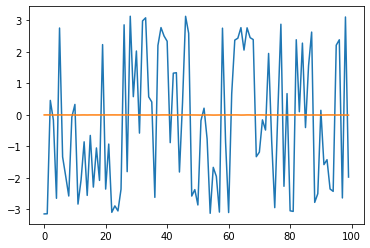

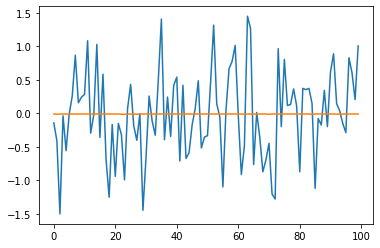

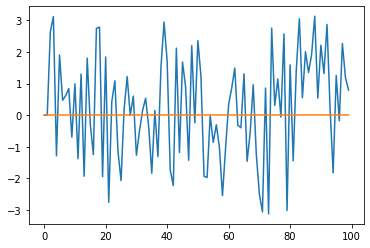

In [259]:
def estimate_rot(data_num=1):
    from scipy.spatial.transform import Rotation as R
    #your code goes here
    ### data loader
    #---------------------------------------------------------------------
    # load the dataset
    number = data_num
    imuRaw = sio.loadmat("./imu/imuRaw" + str(number) + ".mat")
    viconRot = sio.loadmat("./vicon/viconRot" + str(number) + ".mat")
    # load the imu vals & ts
    dataset_vals = imuRaw['vals'].copy()
    dataset_ts = imuRaw['ts'].copy()
    # load the vicon rots & ts
    Vicon_rots = viconRot['rots'].copy()
    Vicon_ts = viconRot['ts'].copy()
    # data samples count
    _, N = dataset_vals.shape
#     print(type(dataset_vals))
    
    ### Pre-process
    #---------------------------------------------------------------------
    ## transform the first 3 dimentions of the dataset, get 3*N dataset
    # define the bias & sensitivity factor for the acc part
    bias = np.array([[np.mean(dataset_vals[0,:100])],
                     [np.mean(dataset_vals[1,:100])],
                     [np.mean(dataset_vals[2,:100])-(np.mean(dataset_vals[2,:100])-np.mean(dataset_vals[1,:100]))]])
#     print("x bias",np.mean(dataset_vals[0,:100]))
#     print("y bias",np.mean(dataset_vals[1,:100]))
#     print("z bias",np.mean(dataset_vals[2,:100]))
#     print(bias.shape)
    
    sens_factor = 0.08
    scale_factor = 3300 / (1023*sens_factor)
    scale_factor = 0.095
    # transform the first 3 dimentions of the dataset, get 3*N dataset
#     print((dataset_vals[:3,:] - bias)*scale_factor)
    imu_acc = (dataset_vals[:3,:] - bias)*scale_factor
    imu_acc[:2,:] = -imu_acc[:2,:]
    print('IMU ACC data:\n', imu_acc)
    '''
    plt.plot(imu_acc[0,:],label="x")
    plt.plot(imu_acc[1,:],label="y")
    plt.plot(imu_acc[2,:],label="z")
    plt.legend()
    plt.show()
    '''
    print("acceleration check:\n", np.sqrt(imu_acc[0,:]**2 + imu_acc[1,:]**2 + imu_acc[2,:]**2 ))
    '''
    plt.plot(np.sqrt(imu_acc[0,:]**2 + imu_acc[1,:]**2 + imu_acc[2,:]**2 ))
    plt.show()
    '''
    
    ## transform the latter 3 dimention of the dataset, get 3*N dataset
    # define the bias & sensitivity factor for the acc part
    bias = np.array([[np.mean(dataset_vals[3,:100])],
                     [np.mean(dataset_vals[4,:100])],
                     [np.mean(dataset_vals[5,:100])]])
    sens_factor = 1
    scale_factor = 3.3/(1023*sens_factor)
#     print((dataset_vals[3:,:] - bias)*scale_factor)
    imu_rot = (dataset_vals[3:,:] - bias)*0.015
    
#     print(imu_rot)
    imu_rot[[0,1,2]] = imu_rot[[1,2,0]]
    print("imu angu",imu_rot)
#     print("norm2 check:", np.sqrt(imu_rot[0,:]**2 + imu_rot[1,:]**2 + imu_rot[2,:]**2 ))
    '''    
    plt.plot(imu_rot[0,:])
    plt.title("imu_rot1")
    plt.show()
    plt.plot(imu_rot[1,:])
    plt.title("imu_rot2")
    plt.show()
    plt.plot(imu_rot[2,:])
    plt.title("imu_rot0")
    plt.show()
    '''
    # concatenate these two transformed dataset
    print("concatenate these two transformed dataset")
    dataset = np.concatenate((imu_acc, imu_rot), axis=0).T
    assert dataset.shape == (N,6)
#     dataset[:,:2] = - dataset[:,:2]
    normal_IMU_vals = dataset
    print("normal_IMU_vals shape:", normal_IMU_vals.shape)
    print(normal_IMU_vals[0,3],normal_IMU_vals[0,4],normal_IMU_vals[0,5])
    normal_IMU_ts = dataset_ts[0]
#     print(normal_IMU_vals)

#     print(dataset_ts)
#     plt.plot(dataset_ts[0])
#     plt.show()
    
    
    ### plot RPY from IMU_acc, IMU_w, and Vicon_rots
    
    RPYVect_constructor = RPYVect()
    Vicon_roll_list, Vicon_pitch_list, Vicon_yaw_list, rots_ts = RPYVect_constructor.rpytsVectFromVicon(Vicon_rots,Vicon_ts)

#     plt.show()
    Acc_roll_list, Acc_pitch_list, normal_IMU_ts = RPYVect_constructor.rpytsVectFromAcc(normal_IMU_vals,normal_IMU_ts)
    
    Angu_roll_list, Angu_pitch_list, Angu_yaw_list, normal_IMU_ts = RPYVect_constructor.rpytsVectFromAnguVel([Vicon_roll_list[0], Vicon_pitch_list[0], Vicon_yaw_list[0]],normal_IMU_vals,normal_IMU_ts)
    
    '''
    plt.plot(Angu_roll_list,label="roll_Angu")
    plt.plot(Vicon_roll_list,label="roll_Vicon")
    plt.plot(Acc_roll_list,label="roll_Acc")
    plt.title("Roll Plot")
    plt.xlabel("time")
    plt.legend()
    plt.show()
    
    plt.plot(Angu_pitch_list,label="pitch_Angu")
    plt.plot(Vicon_pitch_list,label="pitch_Vicon")
    plt.plot(Acc_pitch_list,label="pitch_Acc")
    plt.title("Pitch Plot")
    plt.xlabel("time")
    plt.legend()
    plt.show()
    
    plt.plot(Angu_yaw_list,label="yaw_Angu")
    plt.plot(Vicon_yaw_list,label="yaw_Vicon")
    plt.title("Yaw Plot")
    plt.xlabel("time")
    plt.legend()
    plt.show()
    '''
    
    print("time lens:",normal_IMU_ts.shape)
    
    ### Start UKF
    #---------------------------------------------------------------------
    # init the state, P
    x = np.array([1,0,0,0,normal_IMU_vals[0,3],normal_IMU_vals[0,4],normal_IMU_vals[0,5]])
    # use a random matrix A to generate a PD matrix
    seed = np.random.seed(1)
#     A = np.random.rand(6,6)
#     P = A@A.T
    P = 0.00001*np.eye(6)
    # set a noise PD matrix Q
    Q = 0.00001*np.eye(6)
    R_noise = 0.001*np.eye(6)
    noise_angu_vel = 0.001*np.random.normal(0,1,3)
    noise_acc = 0.001*np.random.normal(0,1,3)
    # start the ukf filter
    ukf = UKF()
    pred_r = []
    pred_p = []
    pred_y = []
    from scipy.spatial.transform import Rotation as R
    for i in range(1,normal_IMU_ts.shape[0]):
        
        print("UKF iteration", i)
        # compute the delta_t for process model use
        delta_t = normal_IMU_ts[i] - normal_IMU_ts[i-1]
        # get the sigma points
        sigma_pts = ukf.SigmaPts(P, Q, x)
        #-----------------------------------
        ## test for init mear
        init_mear = ukf.measureModel(sigma_pts, noise_angu_vel, noise_acc)
        print("init sigma mear",init_mear)
        init_z,_,_ = ukf.measureMeanCov(init_mear)
        print("init mear", init_z)
        #-----------------------------------
        n_pts, _ = sigma_pts.shape
        # project the sigma_pts
        proj_sigma_pts = ukf.processModel(sigma_pts, delta_t)
        # get the mean cov from the projected
        x_hat_bar, P_bar, W_prime = ukf.SigmaPtsMeanCov(proj_sigma_pts,x)
        
        
        mear_pts = ukf.measureModel(proj_sigma_pts, noise_angu_vel, noise_acc)
        true_mear = normal_IMU_vals[i,:]
        print("true mear",true_mear)

        assert true_mear.shape == (6,)
        
        z_bar, P_zz, Z = ukf.measureMeanCov(mear_pts)
        print("pred mear", z_bar)
#         P_xz = Z.T @ W_prime / n_pts
        P_xz = (W_prime.T @ Z) / n_pts
        P_vv = P_zz + R_noise
        K = P_xz @ LA.pinv(P_vv)
        ## Updated x & P
        # update x
        state_cali_6d = K @ (true_mear-z_bar)
        assert state_cali_6d.shape == (6,)
        state_cali_7d = np.hstack((ukf.rotVectToQuat(state_cali_6d[:3]), state_cali_6d[3:]))
        assert state_cali_7d.shape == (7,)
#         print(state_cali_6d.shape)
        x_pred_quat = ukf.quatMultip(x_hat_bar[:4], state_cali_7d[:4])
        x_pred_angu = x_hat_bar[4:] + state_cali_7d[4:]
        x = np.hstack((x_pred_quat,x_pred_angu))
        # update P
        P = P_bar - K @ P_vv @ K.T
        
        
#         print("eigen-value of ",np.linalg.eigvals(P_xz))
#         if not np.all(np.linalg.eigvals(LA.pinv(P_xz)) > 0):
#             print("the P_xz is not PSD")
#         #---------
        
#         #---------
#         if not np.all(np.linalg.eigvals(P) > 0):
#             print("the P is not PSD")
#         #---------
        
        # quat part of x
        x_q = x[:4]
#         print(x_q)
        r = R.from_quat(x_q)
        r,p,y = r.as_euler('xyz', degrees=False)
        pred_r.append(r)
        pred_p.append(p)
        pred_y.append(y)
        
        see = 100
        if i == see:
            break
#         print(x.shape)
#         print(P.shape)
    plt.plot(pred_r)
    plt.plot(Vicon_roll_list[:see])
    plt.show()
    plt.plot(pred_p)
    plt.plot(Vicon_pitch_list[:see])
    plt.show()
    plt.plot(pred_y)
    plt.plot(Vicon_yaw_list[:see])
    plt.show()
        
#         if i == 1:
#             break
        
        
        # compute the delta_t for process model use
#         delta_t = normal_IMU_ts[i] - normal_IMU_ts[i-1]
#         print("UKF iteration", i)
        # get the sigma points
#         sigma_pts = ukf.SigmaPts(P, Q, x)
        # project the sigma points
#         proj_sigma_pts = ukf.processModel(sigma_pts,delta_t)
        # get the 
        
    
    
    
    
#     # init the state, P
# # x = np.array([1,0,0,0,0.0056,0.012,0.0051])
# x = np.array([1,0,0,0,0.01,0.01,0.01])
# # use a random matrix A to generate a PD matrix
# seed = np.random.seed(1)
# # test Sigma_pts
# A = np.random.rand(6,6)
# P = np.eye(6)
# # set a noise PD matrix Q
# Q = np.eye(6)
# R = 0.01*np.eye(6)
# noise_angu_vel = np.random.normal(0,1,3)
# noise_acc = np.random.normal(0,1,3)
# sigma_pts = test.SigmaPts(P, Q, x)
# n_pts, d_7 = sigma_pts.shape
# print("sigma_pts:\n",sigma_pts)
# # print("sigma_pts shape:", sigma_pts.shape)
# proj_sigma_pts = test.processModel(sigma_pts,0.1)
# print("sigma_pts_after_proj(should no change):\n",sigma_pts)
# x_hat_bar, P_k_bar, W_prime = test.SigmaPtsMeanCov(proj_sigma_pts,x)
# mear_pts = measureModel(proj_sigma_pts, noise_angu_vel, noise_acc)
# z_bar, P_zz, Z = test.measureMeanCov(proj_sigma_pts)
# P_xz = Z.T @ W_prime / n_pts
# P_vv = P_zz + R
# K = P_xz @ LA.pinv(P_vv)
# x = x_hat_bar + K@()
    
    
    pass

#     return roll,pitch,yaw
estimate_rot(1)

# Process model

In [277]:
class UKF:
    def __init__(self):
        pass
    def invQuat(self, quat):
        ## get the input quat
        assert quat.shape == (4,)
        return np.array([quat[0], -quat[1], -quat[2], -quat[3]]) / LA.norm(quat)
    def rotVectToQuat(self, rots_vect):
        ## This part need more check, 
        ## if the quat in the scipy package is (vect_part, scale_part) 
        ## then this part is checked
        #------------------------------
        ## the output is (4,)
        '''
        angle = LA.norm(rots_vect)
        axis = rots_vect / angle
        # construct the quat
        scale_part = np.cos(angle/2)
        vect_part = axis * np.sin(angle/2)
        q = np.hstack((scale_part,vect_part))
#         print("rotvect to quat:",q)
        assert q.shape == (4,)
        '''
        r = R.from_rotvec(rots_vect)
        q = r.as_quat()
#         q = q[[3,0,1,2]]
        return q[[3,0,1,2]]
    def quatToRotvect(self, quat):
        q = quat.copy()
        # first change the quat into the function input form
#         print("quat_to_rotation",quat)
        # read in the quat
        r = R.from_quat(q[[1,2,3,0]])
        # change quat to rotvect
        rot_vect = r.as_rotvec()
        assert rot_vect.shape == (3,)
        return rot_vect
    def SigmaPts(self, P, Q, x):
        ## output should be 12*7
        # dimensionality
        n = P.shape[0]
        d = len(x)
        assert d == 7
        sigma_pts = np.zeros((2*n,d))
        # add the noise to P
        P_noise = 2*n*(P + Q)
        # check the PD
        #---------
        if not np.all(np.linalg.eigvals(P_noise) > 0):
            print("the P_noise is not PSD")
        #---------
#         print("P_noise matrix:", P_noise)
        S = LA.cholesky(P_noise).T
#         print("S matrix:", S)
        assert S.shape == (6,6)
        for i in range(S.shape[0]):
            # get one col from S, that is (6,)
            col = S[:,i]
            rot_vect = col[:3]
            # change it into the quat form
#             print("rot vect in SigmaPts, cols:", rot_vect)
            quat = self.rotVectToQuat(rot_vect)
            wi = np.hstack((quat,col[3:]))
            #
            x_pos_q = self.quatMultip(x[:4], wi[:4])
            x_neg_q = self.quatMultip(x[:4], self.invQuat(wi[:4]))
            x_pos_angu = x[4:] + wi[4:]
            x_neg_angu = x[4:] - wi[4:]
            x_pos = np.hstack((x_pos_q, x_pos_angu))
            x_neg = np.hstack((x_neg_q, x_neg_angu))
#             sigma_pts.append(x_pos)
#             sigma_pts.append(x_neg)
            sigma_pts[i,:] = x_pos
            sigma_pts[n+i,:] = x_neg
        assert sigma_pts.shape == (12,7)
        return sigma_pts
        
    def SigmaPtsMeanCov(self, Sigma_pts, x_pre):
#         print("Sigma_points in MeanCov function",Sigma_pts)
        ## input Sigma_pts (12*7)
        n_pts, d = Sigma_pts.shape
        # get the previous quat
        quat_pre = x_pre[:4]
        quat_pre = np.array([np.sqrt(2)/2,np.sqrt(2)/2,0,0])
        # max iterations
        max_iter = 100
        #-----------------------------------------
        # start loop
        mean_quat = quat_pre # init mean
        # interative finding method
        for iters in range(max_iter):
            error_vect = np.zeros((3,)) # init error_vect
            inv_mean_quat = self.invQuat(mean_quat)
            # compute the error vect
            for i in range(n_pts):
                # get the current quat
                quat_i = Sigma_pts[i,:4]
                
                # compute the error_quat
#                 inv_mean_quat = self.invQuat(mean_quat)
                error_quat = self.quatMultip(quat_i, inv_mean_quat)
#                 print("qi",quat_i)
#                 print("inv_mean_quat", inv_mean_quat)
#                 print("error_quat", error_quat)

                error_vect = error_vect + self.quatToRotvect(error_quat)
#                 print("error_vecter",error_vect)
            mean_error_vect = error_vect / n_pts
            mean_error_quat = self.rotVectToQuat(mean_error_vect)
#             print("mean_error_quat", mean_error_quat)
            # early stopping
            if LA.norm(mean_error_quat)< 0.1:
                print("Interitive method find the mean")
                mean_quat = self.quatMultip(mean_error_quat,mean_quat)
                break
            # update the quat
            mean_quat = self.quatMultip(mean_error_quat,mean_quat)
#             print(mean_quat)




        ## find the mean of angu_vel part
        mean_angu_vel = np.mean(sigma_pts[:,4:], axis=0)
        assert mean_angu_vel.shape == (3,)
        # finalize the mean of the sigma points
        mean_sigma_pts = np.hstack((mean_quat,mean_angu_vel))
        #-----------------------------------------
        
        # compute the covariance matrix of the sigma_pts 
        W_matrix = np.zeros((n_pts,6))
        # change the [X-x_bar] to W
        for i in range(n_pts):
            sigma_pt_i = sigma_pts[i,:]
            quat_i = sigma_pt_i[:4]
            unbiased_quat_i = self.quatMultip(quat_i, self.invQuat(mean_quat))
            unbiased_rot_vect_i = self.quatToRotvect(unbiased_quat_i)
            unbiased_angu_vel_i = sigma_pt_i[4:] - mean_angu_vel
            # unbias the quat part
            W_matrix[i, :3] = unbiased_rot_vect_i
            W_matrix[i, 3:] = unbiased_angu_vel_i
        covMatrix_sigma_pts = (W_matrix.T @ W_matrix) / n_pts
        #-----------------------------------------
        
        return mean_sigma_pts, covMatrix_sigma_pts, W_matrix

    def quatMultip(self,q1,q2):
        # this code is checked
        ## this function compute the quaternion multiplication
        # output is (1,4)
        

        return np.array([-q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3] + q1[0] * q2[0],
                         q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2] + q1[0] * q2[1],
                         -q1[1] * q2[3] + q1[2] * q2[0] + q1[3] * q2[1] + q1[0] * q2[2],
                         q1[1] * q2[2] - q1[2] * q2[1] + q1[3] * q2[0] + q1[0] * q2[3]])
#         w0, x0, y0, z0 = q1
#         w1, x1, y1, z1 = q2
#         return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
#                          x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
#                          -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
#                          x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0])
#         u0 = q1[0]
#         v0 = q2[0]
#         u = np.array(q1[1:]).reshape(-1,1)
#         v = np.array(q2[1:]).reshape(-1,1)
# #         print(u)
# #         print(v)
#         # q1, q2 is of shape (4,)
        
#         scale_part = u0*v0-u.T@v
#         vect_part = u0*v.T + v0*u.T + np.cross(u.T,v.T)
# #         print(scale_part)
# #         print(vect_part)
#         q = np.hstack((scale_part,vect_part))
# #         print(q)
#         q = q.reshape(4,)
#         assert q.shape == (4,)
# #         print(q)
#         return q

        
    def processModel(self, sigma_points, delta_t):
         
        ## this method inputs a state and pass it through the process model in UKF
        # sigma_points (12,7) array
        projected_sigma_points = sigma_points.copy()
        
        for i in range(sigma_points.shape[0]):
#             print("state before proj", sigma_points[i,:])
            state = sigma_points[i,:]
            assert state.shape == (7,)
            quat = state[:4]
            angu_vels = state[4:]
            if LA.norm(angu_vels) == 0:
                print("Warning: norm of angu_vels is 0")
            assert quat.shape == (4,)
            # construct delta_quat
            delta_angle = LA.norm(angu_vels) * delta_t
            delta_axis = angu_vels / LA.norm(angu_vels)
            assert delta_axis.shape == (3,)
            delta_quat = np.hstack((np.cos(delta_angle/2), delta_axis*np.sin(delta_angle/2)))
#             print("delta_axisa",delta_axis)
#             print("sin",np.sin(delta_angle/2))
            assert delta_quat.shape == (4,)
#             delta_quat = np.hstack((delta_angle,delta_axis))
            # construct the projected quaternion
#             print("quat_i",quat)
#             print("delta_quat_i",delta_quat)
            proj_quat = self.quatMultip(quat, delta_quat)
            # construct proj state
            proj_state = np.hstack((proj_quat, angu_vels))
            assert proj_state.shape == (7,)
#             print("state after change:", state)
#             print("----------------")
            projected_sigma_points[i,:] = proj_state
#             print("projected state:", proj_state)
#             print("state after proj", sigma_points[i,:])
            
        return projected_sigma_points

    def measureModel(self, proj_sigma_pts,noise_angu_vel,noise_acc):
        ## the output should be N*6
        n_pts, d = proj_sigma_pts.shape
        # gravity
        g = np.array([0,0,0,9.8])
        # init the measure matrix
        mear_matrix = np.zeros((n_pts, 6))
        ## get the acc measurement
        for i in range(n_pts):
            y_i = proj_sigma_pts[i,:]
            quat = y_i[:4]
            # compute the acc measurement
            g_prim_quat_half = self.quatMultip(quat, g)
            g_prim_quat = self.quatMultip(g_prim_quat_half, self.invQuat(quat))
            g_prim = g_prim_quat[1:]
#             g_prim = self.quatToRotvect(g_prim_quat)
            assert g_prim.shape == (3,)
            acc_mear = g_prim + noise_acc
            # compute the angular velocity measurement
            rot_mear = y_i[4:] + noise_angu_vel
            assert rot_mear.shape == (3,)
            # compose the mear
            mear_i = np.hstack((acc_mear, rot_mear))
            mear_matrix[i,:] = mear_i
        assert mear_matrix.shape == (n_pts, 6)
        return mear_matrix
        
    def measureMeanCov(self, measure_pts):
        # get the shape from measure
#         print("mear_matrix", measure_pts)
        n_pts, d = measure_pts.shape
        # get the mean from the measure
        mean_mear = np.mean(measure_pts, axis=0)
#         print("mean of mearsure matrix",mean_mear)
        unbiased_measure = measure_pts - mean_mear.reshape(1,-1)
#         print("unbiased mear_matrix", unbiased_measure)
        # compute the covariance matrix
        covMatrix = (unbiased_measure.T @ unbiased_measure) / n_pts
        
        return mean_mear, covMatrix, unbiased_measure
# from scipy.spatial.transform import Rotation as R
# number = 1
# imuRaw = sio.loadmat("./imu/imuRaw" + str(number) + ".mat")
# viconRot = sio.loadmat("./vicon/viconRot" + str(number) + ".mat")   
    
# imu_ts = imuRaw["ts"]
# imu_vals = imuRaw["vals"]
    
test = UKF()
# print("quatMulti checked")
# print("test for multiplication:",test.quatMultip([1,0,0,0],[0,0,0,9.8]))
# half = test.quatMultip([1,0,0,0],[0,0,0,9.8])
# whole = test.quatMultip(half,[1,0,0,0])
# print(whole)
# r = R.from_quat(whole)
# print(r.as_rotvec())
q1 = np.array([0.8660254,0,0.5,0])
q2 = np.array([0.8660254,0,0.5,0])
print("test for multiplication:",test.quatMultip(q1,q2))
# test_quat = test.rotVectToQuat([np.pi/3,np.pi/3,0])
# r = R.from_rotvec([np.pi/3,np.pi/3,0])
# print("scipy",r.as_quat())
# print("scipy",r.as_quat()[[3,0,1,2]])
# print("scipy",r.as_rotvec().shape)
# print("test quat:", test_quat)
# inv_test_quat = test.invQuat(test_quat)
# print("inv test quat:", inv_test_quat)
# # print(np.cross([2,3,4],[3,2,4]))

# # init the state, P
# # x = np.array([1,0,0,0,0.0056,0.012,0.0051])
# x = np.array([1,0,0,0,0.01,0.01,0.01])
# # use a random matrix A to generate a PD matrix
# seed = np.random.seed(1)
# # test Sigma_pts
# A = np.random.rand(6,6)
# P = np.eye(6)
# # set a noise PD matrix Q
# Q = np.eye(6)
# R_noise = 0.01*np.eye(6)
# noise_angu_vel = np.random.normal(0,1,3)
# noise_acc = np.random.normal(0,1,3)
# sigma_pts = test.SigmaPts(P, Q, x)
# n_pts, d_7 = sigma_pts.shape
# print("sigma_pts:\n",sigma_pts)
# # print("sigma_pts shape:", sigma_pts.shape)
# proj_sigma_pts = test.processModel(sigma_pts,0.1)
# print("sigma_pts_after_proj(should no change):\n",sigma_pts)
# x_hat_bar, P_k_bar, W_prime = test.SigmaPtsMeanCov(proj_sigma_pts,x)
# mear_pts = measureModel(proj_sigma_pts, noise_angu_vel, noise_acc)
# z_bar, P_zz, Z = test.measureMeanCov(proj_sigma_pts)
# P_xz = Z.T @ W_prime / n_pts
# P_vv = P_zz + R_noise
# K = P_xz @ LA.pinv(P_vv)
# x = x_hat_bar + K@()



# print("sigma points mean",mean)


test for multiplication: [0.49999999 0.         0.8660254  0.        ]


In [18]:
from scipy.spatial.transform import Rotation as R
roll = []
pitch = []
yaw = []
for i in range(rots_matries.shape[2]):
    matrix = rots_matries[:,:,i]
    r = R.from_matrix(matrix)
    angle_rots = r.as_euler('xyz', degrees=False)
#     print(angle_rots)
    roll.append(angle_rots[0])
    pitch.append(angle_rots[1])
    yaw.append(angle_rots[2])
print(np.max(roll))
fig,axes = plt.subplots(3,1,figsize=(10,10))

ax = axes[0]
ax.plot(roll)
ax = axes[1]
ax.plot(pitch)
ax = axes[2]
ax.plot(yaw)
plt.title("Ground truth roll-pitch-yaw plot")


NameError: name 'rots_matries' is not defined

In [106]:
0.73814449**2+0.4770444**2*2

1.00000000726008

In [129]:
r = R.from_rotvec([100000,-10000,0])
q = r.as_quat()
print(LA.norm(q))

0.9999999999999999


In [141]:
print(np.zeros((3,)))

[0. 0. 0.]


In [166]:
np.sin(np.pi/2)

1.0

In [175]:
print(np.random.normal(0,1,3))

[0.90159072 0.50249434 0.90085595]


In [201]:
m = np.array([[2,1],
          [1,3]])
n = np.array([1,1])
print((m@n).shape)
print(m@n)

(2,)
[3 4]


In [227]:
temp = np.array([[1,2,3],
                 [1,4,5],
                 [1,6,8]])
temp_mean = np.mean(temp, axis=0)
unbiased_temp = temp - temp_mean.reshape(1,-1)
print(temp_mean)
print(unbiased_temp)

[1.         4.         5.33333333]
[[ 0.         -2.         -2.33333333]
 [ 0.          0.         -0.33333333]
 [ 0.          2.          2.66666667]]


In [270]:
[1,2,3,4]/LA.norm([1,2,3,4])

array([0.18257419, 0.36514837, 0.54772256, 0.73029674])